## 固定亂數

In [1]:
import torch
import numpy as np
import random

def set_seeds(seed):
    random.seed(seed)  # 設定 Python 標準庫的亂數生成器種子
    np.random.seed(seed)  # 設定 NumPy 亂數生成器種子
    torch.manual_seed(seed)  # 設定 PyTorch 的 CPU 亂數生成器種子
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)  # 設定 PyTorch 在單個 GPU 上的亂數種子
        torch.cuda.manual_seed_all(seed)  # 設定 PyTorch 在所有 GPU 上的亂數種子
    torch.backends.cudnn.benchmark = False  # 禁用 cuDNN 的基準測試功能
    torch.backends.cudnn.deterministic = True  # 強制 cuDNN 使用確定性算法

set_seeds(2526)

## 讀取Tokenizer與CSV檔案

In [2]:
from transformers import AutoTokenizer
import pandas as pd
import os

def read_csv_data(data_path):
    source, target = [], []
    for file_name in os.listdir(data_path):
        df = pd.read_csv(f'{data_path}/{file_name}')
        src, tgt = df['text'].values, df['summary'].values
        source.extend(src)
        target.extend(tgt)
    return source, target
    
x_train_data, y_train_data = read_csv_data('news/train')
x_test, y_test = read_csv_data('news/test')

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

## 建立Pytorch DataLoader

In [3]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class SummaryeDataset(Dataset):
    def __init__(self, x, y, tokenizer):
        self.x = x
        self.y = y
        self.tokenizer = tokenizer

    def __getitem__(self, index):
        return self.x[index], self.y[index]
       
    def __len__(self):
        return len(self.x)
    
    def collate_fn(self, batch):    
        batch_x, batch_y = zip(*batch)
        src = self.tokenizer(batch_x, max_length=256, truncation=True, padding="longest", return_tensors='pt')
        tgt = self.tokenizer(batch_y, max_length=256, truncation=True, padding="longest", return_tensors='pt')
        src = {f'src_{k}':v for k, v in src.items()}
        tgt = {f'tgt_{k}':v for k, v in tgt.items()}

        return {**src, **tgt}

x_train, x_valid, y_train, y_valid = train_test_split(x_train_data, y_train_data, train_size=0.8, random_state=46, shuffle=True) 

trainset = SummaryeDataset(x_train, y_train, tokenizer)
validset = SummaryeDataset(x_valid, y_valid, tokenizer)

train_loader = DataLoader(trainset, batch_size = 32, shuffle = True, num_workers = 0, pin_memory = True, collate_fn=trainset.collate_fn)
valid_loader = DataLoader(validset, batch_size = 32, shuffle = True, num_workers = 0, pin_memory = True, collate_fn=validset.collate_fn)

## 建立Positional Encoding

In [4]:
import torch
import torch.nn as nn

class PositionalEncoding(nn.Module):
    def __init__(self, emb_size, dropout, maxlen=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        pe = torch.zeros(maxlen, emb_size)
        position = torch.arange(0, maxlen, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, emb_size, 2).float() * (-torch.log(torch.tensor(10000.0)) / emb_size))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

## 建立Transforemer

In [7]:

class Seq2SeqTransformer(nn.Module):
    def __init__(self, vocab_size, emb_size, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward):
        super(Seq2SeqTransformer, self).__init__()
        self.src_embedding = nn.Embedding(vocab_size, emb_size)
        self.tgt_embedding = nn.Embedding(vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(emb_size, dropout=0.1)

        self.transformer = nn.Transformer(
            d_model=d_model, 
            nhead=nhead,  
            num_encoder_layers=num_encoder_layers, 
            num_decoder_layers=num_decoder_layers, 
            dim_feedforward=dim_feedforward, 
            batch_first=True
        )

        # 用於生成最終輸出的線性層
        self.fc = nn.Linear(d_model, vocab_size)
        self.criterion = torch.nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

    def forward(self, **kwargs):
        src_ids = kwargs['src_input_ids']
        tgt_ids = kwargs['tgt_input_ids']

        src_key_padding_mask = (kwargs['src_attention_mask'] == 0)
        tgt_key_padding_mask = (kwargs['tgt_attention_mask'] == 0)


        src_emb, tgt_emb = self.embedding_step(src_ids, tgt_ids)

        src_mask = torch.zeros((src_emb.shape[1], src_emb.shape[1]),device=device).type(torch.bool)
        tgt_mask = self.generate_square_subsequent_mask(tgt_emb.shape[1])

        # 將嵌入通過transformer模型
        outs = self.transformer(
            src_emb, tgt_emb, 
            src_mask=src_mask, 
            tgt_mask=tgt_mask, 
            src_key_padding_mask=src_key_padding_mask,
            tgt_key_padding_mask=tgt_key_padding_mask, 
            memory_key_padding_mask=src_key_padding_mask
        )

        logits = self.fc(outs)

        tgt_ids_shifted = tgt_ids[:, 1:].reshape(-1)
        logits = logits[:, :-1].reshape(-1, logits.shape[-1])
        loss = self.criterion(logits, tgt_ids_shifted)

        return loss, logits

    def embedding_step(self, src, tgt):
        src_emb = self.src_embedding(src)
        tgt_emb = self.tgt_embedding(tgt)
        
        return self.positional_encoding(src_emb), self.positional_encoding(tgt_emb)
    
    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask.to(device)
    
    def generate(self, max_length=50, cls_token_id=101, sep_token_id=102, **kwargs):
        src_input_ids = kwargs['input_ids']
        src_attention_mask = kwargs['attention_mask']

        # 先嵌入源序列
        src_emb = self.positional_encoding(self.src_embedding(src_input_ids))
        src_key_padding_mask = (src_attention_mask == 0)

        # 初始化目標序列，開始符號 (BOS)
        tgt_input_ids = torch.full((src_input_ids.size(0), 1), cls_token_id, dtype=torch.long).to(src_input_ids.device)
        for _ in range(max_length):
            tgt_emb = self.tgt_embedding(tgt_input_ids)
            tgt_emb = self.positional_encoding(tgt_emb)

            # Transformer 前向傳播
            outs = self.transformer(
                src_emb, tgt_emb, 
                src_key_padding_mask=src_key_padding_mask, 
                memory_key_padding_mask=src_key_padding_mask
            )
            logits = self.fc(outs)
            next_token_logits = logits[:, -1, :]
            next_token = torch.argmax(next_token_logits, dim=-1).unsqueeze(1)
            tgt_input_ids = torch.cat([tgt_input_ids, next_token], dim=1)

            # 停止條件: 如果生成的序列中包含了結束符號 (EOS)
            if next_token.item() == sep_token_id:
                break

        return tgt_input_ids
    
# 設定模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Seq2SeqTransformer(
    vocab_size=len(tokenizer),
    emb_size=512,
    d_model=512,
    nhead=8,
    num_encoder_layers=6,
    num_decoder_layers=6,
    dim_feedforward=2048
).to(device)

## 訓練模型

In [5]:
import torch.optim as optim
from transformers import get_cosine_with_hard_restarts_schedule_with_warmup
from trainer import Trainer

# 優化器與排成器
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
scheduler = get_cosine_with_hard_restarts_schedule_with_warmup(
        optimizer, 
        num_warmup_steps=len(train_loader), 
        num_training_steps=len(train_loader) * 100, 
        num_cycles=1, 
)

# 訓練模型
trainer = Trainer(
    epochs=100, 
    train_loader=train_loader, 
    valid_loader=valid_loader, 
    model=model, 
    optimizer=[optimizer],
    scheduler=[scheduler]
)
trainer.train(show_loss=True)

  0%|          | 0/4643 [00:00<?, ?it/s]c:\Users\user\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
c:\Users\user\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
Valid Epoch 0: 100%|██████████| 1161/1161 [00:34<00:00, 33.95it/s, loss=6.242]


Saving Model With Loss 6.28107
Train Loss: 7.60932| Valid Loss: 6.28107| Best Loss: 6.28107



Valid Epoch 1: 100%|██████████| 1161/1161 [00:33<00:00, 34.19it/s, loss=4.997]


Saving Model With Loss 5.08784
Train Loss: 5.64157| Valid Loss: 5.08784| Best Loss: 5.08784



Valid Epoch 2: 100%|██████████| 1161/1161 [00:34<00:00, 33.98it/s, loss=3.937]


Saving Model With Loss 4.47996
Train Loss: 4.73167| Valid Loss: 4.47996| Best Loss: 4.47996



Valid Epoch 3: 100%|██████████| 1161/1161 [00:33<00:00, 34.32it/s, loss=3.373]


Saving Model With Loss 4.07687
Train Loss: 4.13461| Valid Loss: 4.07687| Best Loss: 4.07687



Valid Epoch 4: 100%|██████████| 1161/1161 [00:34<00:00, 34.14it/s, loss=4.096]


Saving Model With Loss 3.80269
Train Loss: 3.64790| Valid Loss: 3.80269| Best Loss: 3.80269



Valid Epoch 5: 100%|██████████| 1161/1161 [00:33<00:00, 34.48it/s, loss=3.310]


Saving Model With Loss 3.54949
Train Loss: 3.22095| Valid Loss: 3.54949| Best Loss: 3.54949



Valid Epoch 6: 100%|██████████| 1161/1161 [00:33<00:00, 34.57it/s, loss=2.808]


Saving Model With Loss 3.33803
Train Loss: 2.83538| Valid Loss: 3.33803| Best Loss: 3.33803



Valid Epoch 7: 100%|██████████| 1161/1161 [00:33<00:00, 34.24it/s, loss=2.727]


Saving Model With Loss 3.13922
Train Loss: 2.49279| Valid Loss: 3.13922| Best Loss: 3.13922



Valid Epoch 8: 100%|██████████| 1161/1161 [00:33<00:00, 34.61it/s, loss=3.520]


Saving Model With Loss 3.00344
Train Loss: 2.19486| Valid Loss: 3.00344| Best Loss: 3.00344



Valid Epoch 9: 100%|██████████| 1161/1161 [00:33<00:00, 34.89it/s, loss=2.727]


Saving Model With Loss 2.83385
Train Loss: 1.93402| Valid Loss: 2.83385| Best Loss: 2.83385



Valid Epoch 10: 100%|██████████| 1161/1161 [00:33<00:00, 34.53it/s, loss=2.265]


Saving Model With Loss 2.71406
Train Loss: 1.70835| Valid Loss: 2.71406| Best Loss: 2.71406



Valid Epoch 11: 100%|██████████| 1161/1161 [00:33<00:00, 34.50it/s, loss=2.466]


Saving Model With Loss 2.58959
Train Loss: 1.51551| Valid Loss: 2.58959| Best Loss: 2.58959



Valid Epoch 12: 100%|██████████| 1161/1161 [00:33<00:00, 34.56it/s, loss=2.121]


Saving Model With Loss 2.49246
Train Loss: 1.35373| Valid Loss: 2.49246| Best Loss: 2.49246



Valid Epoch 13: 100%|██████████| 1161/1161 [00:33<00:00, 34.56it/s, loss=3.152]


Saving Model With Loss 2.39895
Train Loss: 1.21154| Valid Loss: 2.39895| Best Loss: 2.39895



Valid Epoch 14: 100%|██████████| 1161/1161 [00:33<00:00, 34.71it/s, loss=3.202]


Saving Model With Loss 2.35010
Train Loss: 1.09252| Valid Loss: 2.35010| Best Loss: 2.35010



Valid Epoch 15: 100%|██████████| 1161/1161 [00:33<00:00, 34.40it/s, loss=3.795]


Saving Model With Loss 2.29695
Train Loss: 0.98796| Valid Loss: 2.29695| Best Loss: 2.29695



Valid Epoch 16: 100%|██████████| 1161/1161 [00:33<00:00, 34.67it/s, loss=2.946]


Saving Model With Loss 2.24582
Train Loss: 0.89880| Valid Loss: 2.24582| Best Loss: 2.24582



Valid Epoch 17: 100%|██████████| 1161/1161 [00:33<00:00, 34.70it/s, loss=1.523]


Saving Model With Loss 2.21715
Train Loss: 0.81894| Valid Loss: 2.21715| Best Loss: 2.21715



Valid Epoch 18: 100%|██████████| 1161/1161 [00:34<00:00, 33.75it/s, loss=2.936]


Saving Model With Loss 2.19833
Train Loss: 0.75152| Valid Loss: 2.19833| Best Loss: 2.19833



Valid Epoch 19: 100%|██████████| 1161/1161 [00:33<00:00, 34.39it/s, loss=2.903]


Saving Model With Loss 2.18884
Train Loss: 0.69118| Valid Loss: 2.18884| Best Loss: 2.18884



Valid Epoch 20: 100%|██████████| 1161/1161 [00:33<00:00, 34.50it/s, loss=1.736]


Saving Model With Loss 2.18540
Train Loss: 0.63595| Valid Loss: 2.18540| Best Loss: 2.18540



Valid Epoch 21: 100%|██████████| 1161/1161 [00:33<00:00, 34.64it/s, loss=2.205]


Train Loss: 0.58860| Valid Loss: 2.19564| Best Loss: 2.18540



Valid Epoch 22: 100%|██████████| 1161/1161 [00:33<00:00, 34.85it/s, loss=3.499]


Train Loss: 0.54824| Valid Loss: 2.19679| Best Loss: 2.18540



Valid Epoch 23: 100%|██████████| 1161/1161 [00:33<00:00, 34.53it/s, loss=3.007]


Train Loss: 0.50947| Valid Loss: 2.20367| Best Loss: 2.18540



Valid Epoch 24: 100%|██████████| 1161/1161 [00:33<00:00, 34.62it/s, loss=3.044]


Train Loss: 0.47590| Valid Loss: 2.20252| Best Loss: 2.18540



Valid Epoch 25: 100%|██████████| 1161/1161 [00:34<00:00, 33.98it/s, loss=1.167]


Train Loss: 0.44398| Valid Loss: 2.22525| Best Loss: 2.18540



Valid Epoch 26: 100%|██████████| 1161/1161 [00:33<00:00, 34.68it/s, loss=1.613]


Train Loss: 0.41771| Valid Loss: 2.22996| Best Loss: 2.18540



Valid Epoch 27: 100%|██████████| 1161/1161 [00:34<00:00, 33.97it/s, loss=2.869]


Train Loss: 0.39057| Valid Loss: 2.24900| Best Loss: 2.18540



Valid Epoch 28: 100%|██████████| 1161/1161 [00:34<00:00, 33.79it/s, loss=1.396]


Train Loss: 0.36880| Valid Loss: 2.25500| Best Loss: 2.18540



Valid Epoch 29: 100%|██████████| 1161/1161 [00:33<00:00, 34.50it/s, loss=0.950]


Train Loss: 0.34809| Valid Loss: 2.26407| Best Loss: 2.18540



Valid Epoch 30: 100%|██████████| 1161/1161 [00:34<00:00, 33.98it/s, loss=1.642]


------------------------------------
|Model can't improve, stop training|
------------------------------------


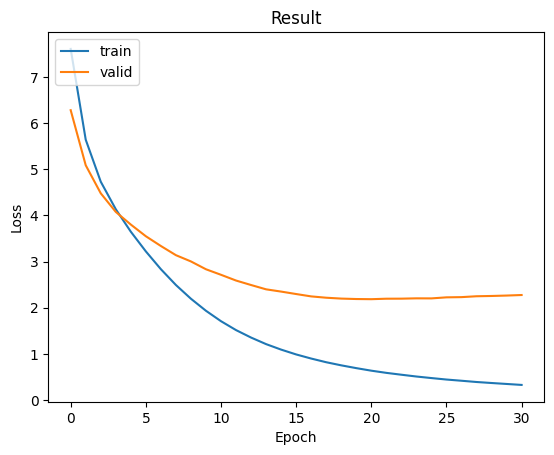

## 驗證模型生成結果

In [36]:
model.load_state_dict(torch.load('model.ckpt'))
model.eval()
idx = 7778
input_data = tokenizer(x_test[idx], max_length=1024, truncation=True, padding="longest", return_tensors='pt').to(device)
generated_ids = model.generate(**input_data, max_len=50)

print('輸入文字:\n', x_test[idx])
print('目標文字:\n', y_test[idx])
print('模型文字:\n', tokenizer.decode(generated_ids[0]))

輸入文字:
 mandsaur police tuesday filed 350page chargesheet two accused eightyearold girls gangrape case chargesheet names 92 witnesses lists 100 pieces evidence accused girl allegedly kidnapped waiting family member outside school raped secluded place
目標文字:
 92 witnesses 100 evidences mandsaur gangrape chargesheet
模型文字:
 [CLS] 92 witnesses 100 evidences mandsaur gangrape chargesheet [SEP]
